[toc]

本部分使用Estimator的方式实现逻辑回归。

（1）使用csv格式的泰坦尼克号数据作为数据集。

In [82]:
import tensorflow as tf
import pandas as pd
from IPython.display import clear_output
print(tf.__version__)
print(pd.__version__)

2.3.0
1.0.1


## 1、加载csv格式的数据集并生成Dataset

### 1.1 pandas读取csv数据生成Dataframe

In [83]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

我们看一下数据：

In [84]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [85]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


训练数据和验证数据的数量分别为：

In [86]:
dftrain.shape,dfeval.shape

((627, 9), (264, 9))

看看年龄的分布：

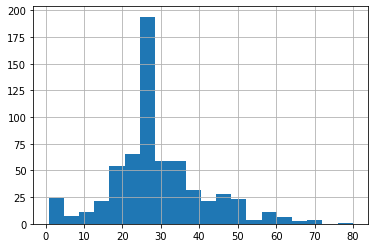

In [87]:
#将数字划分成bins份，统计每份的数量，并作直方图
dftrain.age.hist(bins=20)
#dftain.age等同于dftrain['age']，pandas会为每列数据生成一个同名的变量

再看看性别：

In [88]:
dftrain.sex.value_counts()

male      410
female    217
Name: sex, dtype: int64

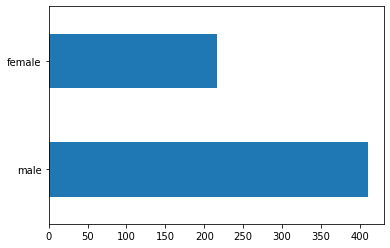

In [89]:
#以图标方式显示
dftrain.sex.value_counts().plot(kind='barh')

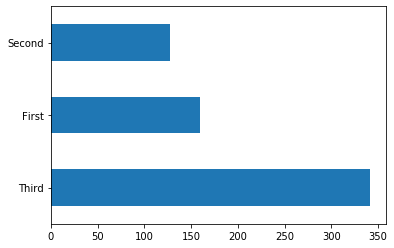

In [90]:
#再看看仓位
dftrain['class'].value_counts().plot(kind='barh')

看看男女的survivid比例：

In [91]:
pd.concat([dftrain,y_train],axis=1).groupby('sex').survived.mean()

sex
female    0.778802
male      0.180488
Name: survived, dtype: float64

Text(0.5, 0, '% survived')

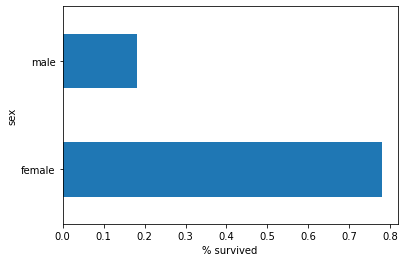

In [92]:
pd.concat([dftrain,y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survived')

### 1.2 将Dataframe生成Dataset
使用上面的训练数据生成tf.data.Dataset:

In [114]:
#本行代码只是示范了如何将Dataframe转换成Dataset，下面并未用到这个变量。
dataset = tf.data.Dataset.from_tensor_slices((dict(dftrain),y_train))
for ds in dataset:
    print(ds)

({'sex': <tf.Tensor: shape=(), dtype=string, numpy=b'male'>, 'age': <tf.Tensor: shape=(), dtype=float64, numpy=22.0>, 'n_siblings_spouses': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'parch': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'fare': <tf.Tensor: shape=(), dtype=float64, numpy=7.25>, 'class': <tf.Tensor: shape=(), dtype=string, numpy=b'Third'>, 'deck': <tf.Tensor: shape=(), dtype=string, numpy=b'unknown'>, 'embark_town': <tf.Tensor: shape=(), dtype=string, numpy=b'Southampton'>, 'alone': <tf.Tensor: shape=(), dtype=string, numpy=b'n'>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
({'sex': <tf.Tensor: shape=(), dtype=string, numpy=b'female'>, 'age': <tf.Tensor: shape=(), dtype=float64, numpy=38.0>, 'n_siblings_spouses': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'parch': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'fare': <tf.Tensor: shape=(), dtype=float64, numpy=71.2833>, 'class': <tf.Tensor: shape=(), dtype=string, numpy=b'First'>, 'deck': <tf.Tensor: shape=(), dtype=

({'sex': <tf.Tensor: shape=(), dtype=string, numpy=b'male'>, 'age': <tf.Tensor: shape=(), dtype=float64, numpy=44.0>, 'n_siblings_spouses': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'parch': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'fare': <tf.Tensor: shape=(), dtype=float64, numpy=7.925>, 'class': <tf.Tensor: shape=(), dtype=string, numpy=b'Third'>, 'deck': <tf.Tensor: shape=(), dtype=string, numpy=b'unknown'>, 'embark_town': <tf.Tensor: shape=(), dtype=string, numpy=b'Southampton'>, 'alone': <tf.Tensor: shape=(), dtype=string, numpy=b'y'>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
({'sex': <tf.Tensor: shape=(), dtype=string, numpy=b'female'>, 'age': <tf.Tensor: shape=(), dtype=float64, numpy=28.0>, 'n_siblings_spouses': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'parch': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'fare': <tf.Tensor: shape=(), dtype=float64, numpy=8.05>, 'class': <tf.Tensor: shape=(), dtype=string, numpy=b'Third'>, 'deck': <tf.Tensor: shape=(), dtype=st

({'sex': <tf.Tensor: shape=(), dtype=string, numpy=b'male'>, 'age': <tf.Tensor: shape=(), dtype=float64, numpy=47.0>, 'n_siblings_spouses': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'parch': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'fare': <tf.Tensor: shape=(), dtype=float64, numpy=25.5875>, 'class': <tf.Tensor: shape=(), dtype=string, numpy=b'First'>, 'deck': <tf.Tensor: shape=(), dtype=string, numpy=b'E'>, 'embark_town': <tf.Tensor: shape=(), dtype=string, numpy=b'Southampton'>, 'alone': <tf.Tensor: shape=(), dtype=string, numpy=b'y'>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
({'sex': <tf.Tensor: shape=(), dtype=string, numpy=b'male'>, 'age': <tf.Tensor: shape=(), dtype=float64, numpy=36.0>, 'n_siblings_spouses': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'parch': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'fare': <tf.Tensor: shape=(), dtype=float64, numpy=7.4958>, 'class': <tf.Tensor: shape=(), dtype=string, numpy=b'Third'>, 'deck': <tf.Tensor: shape=(), dtype=string

In [93]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    #从Dataframe中构建Dataset
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [94]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())


Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Second' b'Second' b'Third' b'Second' b'Third' b'Third' b'Third'
 b'Third' b'Third' b'Third']

A batch of Labels: [0 0 0 1 0 0 0 1 0 0]


In [95]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[23.],
       [28.],
       [32.],
       [31.],
       [28.],
       [ 4.],
       [28.],
       [25.],
       [35.],
       [28.]], dtype=float32)

In [96]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## 2、将数据封装成Feature columnn

In [97]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype=tf.float32))
    

In [98]:
feature_columns[5]

VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

## 3、构建并训练模型
使用tensorflow预构建的LinearClassfier可以很方便的构建和训练模型：

In [99]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.75, 'accuracy_baseline': 0.625, 'auc': 0.825375, 'auc_precision_recall': 0.7897542, 'average_loss': 0.5112618, 'label/mean': 0.375, 'loss': 0.50658554, 'precision': 0.6386555, 'prediction/mean': 0.47108686, 'recall': 0.7676768, 'global_step': 200}


## 4、构建组合特征
上述特征使用的都是单一特征，但有时候特征的组合和结果的相关性更高。比如单从性别年龄都很难看出结果，但某个年龄+性别的组合，可能就和结果的相关性很高了。

In [100]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)


{'accuracy': 0.7765151, 'accuracy_baseline': 0.625, 'auc': 0.85026014, 'auc_precision_recall': 0.7782748, 'average_loss': 0.48670053, 'label/mean': 0.375, 'loss': 0.4771559, 'precision': 0.7631579, 'prediction/mean': 0.29976445, 'recall': 0.5858586, 'global_step': 200}


## 5、预测数据

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/vx/w_50bfjj6xn9j5_lqhfrbcv00000gn/T/tmpo5ivmpz_/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


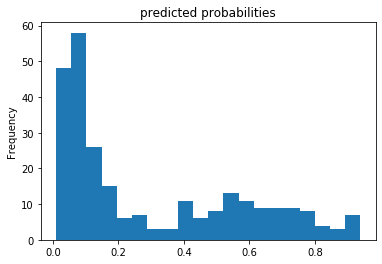

In [101]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')


计算ROC：

(0, 1.05)

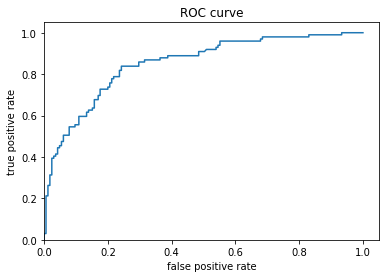

In [102]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
